# Progetto di Deep Learning

**Studente** : Lorenzo Pagnini

**Matricola**: 942265

**Email**: lorenzo.pagnini2@studio.unibo.it

**Corso**: Deep Learning

20 Dicembre 2021.

---------------------------


**Abstract**

Il progetto ha come scopo quello di addestrare una rete neurale di object detection per il riconoscimento e la localizzazione di luoghi ad alto valore culturale come ad esempio: ville, palazzi storici, monumenti e fontane.

Questi luoghi appartengono alla città di **Pesaro**.

La rete neurale scelta per questo tipo di problema (da applicarsi in contesti non real-time) è la **Faster R-CNN** poichè risulta essere una delle più veloci e performanti per questo tipo di contesto. Data la piccola dimensione del dataset si è deciso di utilizzare una rete pre-addestrata. 

Il progetto si basa sul [Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) di PyTorch per l'addestramento della Faster R-CNN pre-addestrata.

Il codice è ben documentato e per ogni sezione ho riportato una descrizione sintetica delle funzioni implementate.

## Librerie

In [1]:
# Core libraries
import os
import re
import math
import random
import time
import numpy as np
import glob
import natsort
import datetime
from datetime import date
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
import statistics
from collections import Counter

# PyTorch
import torch
import torchvision
import torchvision.transforms.functional as torch_da
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

!pip install -qU torch_snippets
from torch_snippets import *

# Opencv and PIL
import cv2 as cv
import PIL
from PIL import Image
from google.colab.patches import cv2_imshow

# Google drive
from google.colab import drive

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 43 kB 920 kB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 214 kB 33.4 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 10.1 MB 48.5 MB/s 
     |████████████████████████████████| 51 kB 7.8 MB/s 


## Funzioni di utilità

Sono presenti le seguenti funzioni:

- **split_directory()**: permette letteralmente di _splittare_ (aggiungere spazi bianchi) alla stringa data in input.

- **get_bbs()**: restituisce le coordinate delle bounding boxes, scalate rispetto alla dimensione dell'immagine.

- **parse_file()**: parsa il file _xml_ dato in input, per estrarre le informazioni di interesse.

- **format_labels()**: formatta in modo appropriato la classe del dataset.

- **stack_images()**: crea una griglia N x M di immagini.

- **draw_description()**: aggiunge in fondo all'immagine la sua classe di appartenenza.

In [2]:
def split_directory(title):
    """
    Split text of the directory.

    :param title  : text to split.

    :return       : text with the tabulations.
    """
    
    title = title[0].upper() + title[1:]
    folder = re.findall('[A-Z][^A-Z]*', title)
    result = ""

    for i, item in enumerate(folder):
        result += str(item) + (" " if (i + 1) != len(folder) else "")

    return result

def get_bbs(annotation_path, x_scale, y_scale):
  """
  Get bounding boxes from specific annotation file.

  :param annotation_path: path of the file xml.
  :param x_scale        : x-coordinate scale factor.
  :param y_scale        : y-coordinate scale factor.
  
  :return bb            : list of the bounding boxes.
  :return labels        : list of the labels.
  """

  bbs    = []
  labels = []

  _bbs, _labels = parse_file(annotation_path)

  for box, label in zip(_bbs, _labels):

    labels.extend([label])
  
    # Extracting scaled coordinates for the size of the current image
    x_min = np.round(box[0][0] * x_scale)
    x_max = np.round(box[1][0] * x_scale)
    y_min = np.round(box[0][1] * y_scale)
    y_max = np.round(box[1][1] * y_scale)

    x_min, y_min, x_max, y_max = [int(x) for x in [x_min, y_min, x_max, y_max]]
    bbs.append([x_min, y_min, x_max, y_max])

  return bbs, labels

def parse_file(file):
  """
  Get all bounding boxes of a specific file xml.

  :param file           : file from which to get bounding boxes.

  :return bounding_box  : coordinates of the objects of the file.
  :return format_labels : new format labels.
  """

  bounding_box = []
  labels = []

  tree = ET.parse(file)
  root = tree.getroot()

  # Get all bounding boxes
  j = 6
  while True:
      try:
          object = root[j]

          labels.append(object[0].text)

          box = object[4]
          
          x_min, y_min, x_max, y_max = int(box[0].text), int(box[1].text), int(box[2].text), int(box[3].text)
          
          bounding_box.append([[x_min, y_min], [x_max, y_max]])

          j += 1
          
      except Exception as e:
          # End loop
          break

  return bounding_box, format_labels(labels)

def format_labels(labels):
  """
  Match the labels between label of the bb and name directory.

  :param labels : list containing the labels to math.

  :return result: new format labels.
  """

  result = []
  for label in labels:

    if label == "Scultura della Memoria":
      result.append("Scultura Della Memoria")
      
    elif label == "Palla di Pomodoro":
      result.append("Palla Di Pomodoro")

    elif label == "Arco di Trionfo":
      result.append("Arco Di Trionfo")

    elif label == "Palazzo delle Poste":
      result.append("Palazzo Delle Poste")

    elif label == "Fontana Piazza del Popolo":
      result.append("Fontana Piazza")

    elif label == "Giulio Perticari":
      result.append("Statua Giulio Perticari")
      
    else:
      result.append(label)
  
  return result

def stack_images(scale, img_array):
    """
    Code originally from https://github.com/murtazahassan/OpenCV-Python-Tutorials-and-Projects
    Stack the images based on the number of them by rows and columns.

    :param scale    : scale factor.
    :param img_array: array of images.

    :return         : array of images to show.
    """

    rows = len(img_array)
    cols = len(img_array[0])

    rowsAvailable = isinstance(img_array[0], list)

    width = img_array[0][0].shape[1]
    height = img_array[0][0].shape[0]

    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):

                if img_array[x][y].shape[:2] == img_array[0][0].shape[:2]:
                    img_array[x][y] = cv.resize(img_array[x][y], (0, 0), None, scale, scale)
                else:
                    img_array[x][y] = cv.resize(img_array[x][y], (img_array[0][0].shape[1], img_array[0][0].shape[0]),
                                                None, scale, scale)

                if len(img_array[x][y].shape) == 2:
                    img_array[x][y] = cv.cvtColor(img_array[x][y], cv.COLOR_GRAY2BGR)

        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows

        for x in range(0, rows):
            hor[x] = np.hstack(img_array[x])
        ver = np.vstack(hor)

    else:
        for x in range(0, rows):

            if img_array[x].shape[:2] == img_array[0].shape[:2]:
                img_array[x] = cv.resize(img_array[x], (0, 0), None, scale, scale)
            else:
                img_array[x] = cv.resize(img_array[x], (img_array[0].shape[1], img_array[0].shape[0]), None, scale,
                                         scale)

            if len(img_array[x].shape) == 2:
                img_array[x] = cv.cvtColor(img_array[x], cv.COLOR_GRAY2BGR)

        hor = np.hstack(img_array)
        ver = hor

    return ver

def draw_description(img, text):
    """
    Draw description image.

    :param text : image description.
    :param img  : image in which to insert the descrition.
    
    :return     : image with description.
    """

    bottom = int(0.04 * img.shape[0])
    img = cv.copyMakeBorder(img, 0, bottom, 0, 0, cv.BORDER_CONSTANT, None, (255, 255, 255))

    height, _, _ = img.shape
    cv.putText(img, text, (0, height - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    return img

## Dataset

Sono stati individuati **24 punti di interesse** suddivisi in altrettante directories. 



Ogni punto di interesse contiene, a sua volta, altre tre directory:
- *imgs*: contiene le immagini di dimensione 900 x 1300;
- *annotations*: contiene un file _xml_ in cui sono presenti le annotazioni  (coordinate delle bounding box) in formato PASCAL VOC, di ogni immagine catturata;
- *bounding_box*: contiene le immagini con le bouding box individuate.


Il dataset è consultabile al seguente [link](https://drive.google.com/drive/folders/1MenVMP6C9Vuo7JJ-iesAd1KfsemAvSLy?usp=sharing).

Il dataset è stato etichettato con il tool _labelImg_ consultabile al seguente [link](https://github.com/tzutalin/labelImg).

-----

Le immagini totali sono **953**. Le immagini possono contenere un unico oggetto o più di uno, eccetto tutte quelle appartenenti alla classe _Background_ che non contengono oggetti.

----
**Esempio di annotazzione** in formato PASCAL VOC.

Viene mostrato un esempio di annotazione (file _xml_). Come è possibile notare, per ogni oggetto sono presenti le 4 coordinate che inviduano la bounding box e la classe di appartenenza. In questa immagini sono presenti 2 oggetti rispettivamente di classe _Fontana Piazza del Popolo_ e _Palazzo delle Poste_.

```
<annotation>
	<folder>Fontana Piazza</folder>
	<filename>_MG_9055.JPG</filename>
	<path>C:/Users/Lorenzo/Desktop/Progetti/PyCharm/CulturalHeritage/DatasetMonuments/fontanaPiazza/imgs/_MG_9055.JPG</path>
	<source>
		<database>Cultural Heritage Pesaro</database>
	</source>
	<size>
		<width>1300</width>
		<height>900</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>Fontana Piazza del Popolo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>518</xmin>
			<ymin>387</ymin>
			<xmax>871</xmax>
			<ymax>618</ymax>
		</bndbox>
	</object>
	<object>
		<name>Palazzo delle Poste</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1</xmin>
			<ymin>65</ymin>
			<xmax>921</xmax>
			<ymax>565</ymax>
		</bndbox>
	</object>
</annotation>
```

Connessione a google drive per scaricare il dataset.

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


### Classi di gestione

- **SingleClassDataset**: utilizzata per rappresentare ogni classe del dataset.

- **DatasetCulturalHeritage**: utilizzata per contenere tutte le immagini di tutte le classi (e relative annotazioni) rispettivamente per il training, validation e test set.

Classe per ottenere informazioni sulle immagini appartenenti ad una specfica classe (label) del dataset.

In [4]:
class SingleClassDataset(Dataset):
  """
  Class to load the dataset of the specific class.
  """

  def __init__(self, dir, path, height=224, width=224, shuffle=False):
      """
      Load the dataset of the specific class.

      :param dir  : directory containing images.
      :param path : path of the dataset.
      :param height   : height of the image to be resized.
      :param width    : width of the image to be resized.
      :param shuffle  : if true, shuffle data.
      """

      self.dir          = dir
      self.label        = split_directory(dir)
      self.path         = path

      self.imgs         = glob.glob(self.path + self.dir + '/imgs/*.JPG') + glob.glob(self.path + self.dir + '/imgs/*.jpg')
      self.annotations  = glob.glob(self.path + self.dir + '/annotations/*.xml')

      self.imgs.sort()
      self.annotations.sort()

      # Shuffle data
      if shuffle:
        zipped_data = list(zip(self.imgs,  self.annotations))
        random.shuffle(zipped_data)
        self.imgs,  self.annotations = zip(*zipped_data)

      self.height       = height
      self.width        = width

  def __getitem__(self, ix):
      """
      Get the image, its bounding boxes and labels.
      
      :param ix: index of the image of the specifi class.
      """

      img_path, annotations_path = self.imgs[ix], self.annotations[ix]
      img = cv.imread(img_path)
      
      bbs, labels = parse_file(annotations_path)

      return img_path, img, bbs, labels

  def __len__(self):
      assert len(self.imgs) == len(self.annotations)
      return len(self.imgs)

Classe per caricare tutte le immagini del dataset.

Questa classe è di fondamentale importanza poichè è quella che viene utilizzata durante l'addestramento del modello per il training e validation set. Nel metodo **\_\_getitem__()** è implementata la logica per ottenere le varie immagini (originali e di data augmentation) con rispettivi valori di target (coordinate e labels). 

In [5]:
def preprocess_image(img):
    """ Image preprocessing """

    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

class DatasetCulturalHeritage(Dataset):
  """
  Class to load all the dataset.
  """

  def __init__(self, imgs, anns, path, train=False, height=224, width=224):
      """
      Load the dataset.

      :param imgs     : path of images.
      :param anns     : path of annotations.
      :param height   : height of the image to be resized.
      :param width    : width of the image to be resized.
      :param path     : path of the dataset.
      """

      self.train = train
      self.path         = path
      self.imgs         = imgs

      self.imgs_contrast  = []
      self.imgs_flip      = []
      self.imgs_rotate    = []
      self.num_splitting  = 0

      if self.train and data_augmentation:
        self.imgs_contrast  =  list(filter(lambda x : type(x) == DataAugmentationContrast, self.imgs))[0]
        self.imgs_flip      =  list(filter(lambda x : type(x) == DataAugmentationFlipping, self.imgs))[0]
        self.imgs_rotate    =  list(filter(lambda x : type(x) == DataAugmentationRotate, self.imgs))[0]
        self.imgs           =  list(filter(lambda x : type(x) == str, self.imgs))
        self.num_splitting  =  len(self.imgs_contrast)  # or len(self.imgs_flip) or len(self.imgs_rotate)
      
      self.annotations  = anns

      self.imgs.sort()
      self.annotations.sort()

      self.height     = height
      self.width      = width
    
  def __getitem__(self, ix):
      """
      Get the image.

      :param ix: index of the specific image.
      """

      if self.train:

          # Train set
          if ix >= 0 and ix < len(self.imgs):

            # Image path
            img_path, annotation_path = self.imgs[ix], self.annotations[ix]

            img = Image.open(img_path).convert("RGB")
            width, height = img.size

            img = np.array(img.resize((self.width, self.height), resample=Image.BILINEAR)) / 255.
            
            x_scale = self.width / width
            y_scale = self.height / height

            bbs, labels = get_bbs(annotation_path, x_scale, y_scale)

          elif ix >= len(self.imgs) and ix < len(self.imgs) + self.num_splitting:

            # Data Augmentation Contrast
            ix = ix - len(self.imgs)
            img, annotation_path, width, height = self.imgs_contrast[ix]

            x_scale = self.width / width
            y_scale = self.height / height

            bbs, labels = get_bbs(annotation_path, x_scale, y_scale)

          elif ix >= len(self.imgs) + self.num_splitting and ix < len(self.imgs) + self.num_splitting * 2:

              # Data Augmentation Flipping
              ix = ix - (len(self.imgs) + self.num_splitting)
              img, bbs, labels = self.imgs_flip[ix]

          elif ix >= len(self.imgs) + self.num_splitting * 2 and ix < len(self.imgs) + self.num_splitting * 3:

              # Data Augmentation Rotate
              ix = ix - (len(self.imgs) + self.num_splitting * 2)
              img, bbs, labels = self.imgs_rotate[ix]
      else:

          # Validation and test set
          img_path, annotation_path = self.imgs[ix], self.annotations[ix]

          img = Image.open(img_path).convert("RGB")
          width, height = img.size

          img = np.array(img.resize((self.width, self.height), resample=Image.BILINEAR)) / 255.

          x_scale = self.width / width
          y_scale = self.height / height

          bbs, labels = get_bbs(annotation_path, x_scale, y_scale)

      if len(bbs) == 0:

        # Background image
        labels.extend(['Background'])                      # Label 0 = background class
        bbs = [[0, 1, 2, 3]]
        boxes = torch.Tensor(bbs).float()                  # Fake bounding box
        
      else:
        # Image with object 
        boxes = torch.Tensor(bbs).float()    

      target = {}
      target["image_id"]  = torch.Tensor([ix])
      target["boxes"]     = boxes
      target["labels"]    = torch.Tensor([label2target[i] for i in labels]).long()

      img = preprocess_image(img)
      return img, target

  def __len__(self):
      assert len(self.imgs) == len(self.annotations)
      return len(self.imgs) + len(self.imgs_contrast) + len(self.imgs_flip) + len(self.imgs_rotate)

  def collate_fn(self, batch):
      return tuple(zip(*batch))

### Data augmentation

Questa sezione contiene le classi e funzioni per poter implementare la data augmentation.

Si tratta di una tecnica che consiste nell'aumentare la dimensione del training set applicando una serie di trasformazioni alle immagini che lo compongono. Questo significa creare una copia dell'immagine originale e applicare la trasformazione.

La trasformazioni implementate sono:
- flipping orrizzontale;
- rotazione di un angolo compreso nel range [- 90°, - 30°] o nel range [+ 30°, + 90°].
- cambiamento del contrasto.


In questo modo, la rete non apprende solamente l'oggetto originale ma anche le sue trasformazioni conferendoli una maggior robustezza e stabilità durante le predizioni.

Funzioni per eseguire le trasformazioni di cambiamento del contrasto, flipping orizzontale e rotazione.

- **_random()**: estrae un numero casuale tra 0 e 1. Utilizzata per estrarre la probabilità per eseguire una rotazione di un angolo compreso tra [-90°, -30°] o tra [30°, 90°].

- **adjust_contrast()**: modifica il contrasto di una immagine di un fattore multiplo di 2 compreso tra [2, 4].

- **flip()**: esegue il flipping orizzontale di una immagine.

- **rotate()**: esegue una rotazione casuale a sinistra di un angolo compreso tra [-90°, -30°] (o a destra di un angolo compreso tra [30°, 90°]) di una immagine.

In [9]:
# Code originally from https://github.com/anhtuan85/Data-Augmentation-for-Object-Detection

def _random():
  """ 50% random probability """

  return np.random.randint(0, 2)

def adjust_contrast(image):
  """
  Adjust contrat of the image.

  :param image: input image

  :return image after transformation.
  """

  # Contrast_factor is equal to [2, 4]
  contrast_factor = np.random.randint(2, 4) 
  if contrast_factor % 2 != 0:
    contrast_factor +=1

  return torch_da.adjust_contrast(image, contrast_factor)

def flip(image, boxes):
    """
    Flip image horizontally.

    :param image: a PIL image
    :param boxes: Bounding boxes, a tensor of dimensions (#objects, 4)

    :return new_images : new images after flipping.
    :retrun new_boxes  : new boxes after flipping.
    """
    new_image = torch_da.hflip(image)
    
    if len(boxes) > 0:
      new_boxes = boxes.clone()
      new_boxes[:, 0] = image.width - boxes[:, 0]
      new_boxes[:, 2] = image.width - boxes[:, 2]
      new_boxes = new_boxes[:, [2, 1, 0, 3]]

    else: new_boxes = boxes

    return new_image, new_boxes

def rotate(image, boxes, angle, width=224, height=224):
    """
    Rotate image and bounding box

    :param image       : A Pil image.
    :param boxes       : A tensors of dimensions (#objects, 4)
    :param angle       : angle of the rotation.
    :param width       : final width after rotation.
    :param height      : final height after rotation.
        
    :return new_images : new images after rotation.
    :retrun new_boxes  : new boxes after rotation.
    """
    new_image = image.copy()
    new_boxes = boxes.clone()
    
    # Rotate image, expand = True
    w = image.width
    h = image.height
    cx = w / 2
    cy = h / 2

    angle = np.random.randint(30, 90)
    if _random():
      angle = - angle

    new_image = new_image.rotate(angle, expand=True)

    if len(boxes) > 0:

      angle = np.radians(angle)
      alpha = np.cos(angle)
      beta = np.sin(angle)

      # Get affine matrix
      affine_matrix = torch.tensor([[alpha, beta, (1-alpha)*cx - beta*cy],
                                  [-beta, alpha, beta*cx + (1-alpha)*cy]])
      
      # Rotation boxes
      box_width = (boxes[:,2] - boxes[:,0]).reshape(-1,1)
      box_height = (boxes[:,3] - boxes[:,1]).reshape(-1,1)
      
      # Get corners for boxes
      x1 = boxes[:,0].reshape(-1,1)
      y1 = boxes[:,1].reshape(-1,1)
      
      x2 = x1 + box_width
      y2 = y1 
      
      x3 = x1
      y3 = y1 + box_height
      
      x4 = boxes[:,2].reshape(-1,1)
      y4 = boxes[:,3].reshape(-1,1)
      
      corners = torch.stack((x1, y1, x2, y2, x3, y3, x4, y4), dim= 1)
      corners.reshape(-1, 8)                                                            # Tensors of dimensions (#objects, 8)
      corners = corners.reshape(-1,2)                                                   # Tensors of dimension (4* #objects, 2)
      corners = torch.cat((corners, torch.ones(corners.shape[0], 1)), dim= 1).double()  # (Tensors of dimension (4* #objects, 3))

      cos = np.abs(affine_matrix[0, 0])
      sin = np.abs(affine_matrix[0, 1])
      
      nW = int((h * sin) + (w * cos))
      nH = int((h * cos) + (w * sin))

      affine_matrix[0, 2] += (nW / 2) - cx
      affine_matrix[1, 2] += (nH / 2) - cy
      
      # Apply affine transform
      rotate_corners = torch.mm(affine_matrix, corners.t()).t()
      rotate_corners = rotate_corners.reshape(-1,8)
      
      x_corners = rotate_corners[:,[0,2,4,6]]
      y_corners = rotate_corners[:,[1,3,5,7]]
      
      # Get (x_min, y_min, x_max, y_max)
      x_min, _ = torch.min(x_corners, dim= 1)
      x_min = x_min.reshape(-1, 1)

      y_min, _ = torch.min(y_corners, dim= 1)
      y_min = y_min.reshape(-1, 1)

      x_max, _ = torch.max(x_corners, dim= 1)
      x_max = x_max.reshape(-1, 1)

      y_max, _ = torch.max(y_corners, dim= 1)
      y_max = y_max.reshape(-1, 1)
      
      new_boxes = torch.cat((x_min, y_min, x_max, y_max), dim= 1)

    else:
      new_boxes = boxes
    
    scale_x = new_image.width / w
    scale_y = new_image.height / h
    
    # Resize new image to (w, h)
    new_image = new_image.resize((width, height))
    
    # Resize boxes
    if len(boxes) > 0: 
      new_boxes /= torch.Tensor([scale_x, scale_y, scale_x, scale_y])
      new_boxes[:, 0] = torch.clamp(new_boxes[:, 0], 0, w)
      new_boxes[:, 1] = torch.clamp(new_boxes[:, 1], 0, h)
      new_boxes[:, 2] = torch.clamp(new_boxes[:, 2], 0, w)
      new_boxes[:, 3] = torch.clamp(new_boxes[:, 3], 0, h)

    return new_image, new_boxes.float()

Classi di gestione per implementare la **data augmentation** delle relative trasformazioni applicate.

Per eseguire diversi addestramenti con un numero differente di immagini di data augmentation, le immagini vengono create e memorizzate a runtime solo per uno specifico addestramento. Questo significa che nel dataset 'fisico' (condiviso su google drive) troverete solo immagini originali.

La classi di riferimento sono:

- **DataAugmentationContrast()**: classe per creare immagini con contrasto modificato.

- **DataAugmentationFlipping()**: classe per creare immagini con flipping orizzontale.

- **DataAugmentationRotate()**: classe per creare immagini con rotazione.

In [ ]:
class DataAugmentationContrast(Dataset):
  """
  Data Augmentation to change the constrast of the images.
  """

  def __init__(self, img_path, path_ann, height=224, width=224):

    self.img_path = img_path
    self.path_ann = path_ann

    self.img_path.sort()
    self.path_ann.sort()

    self.image_contrast = [None for i in range(len(self.img_path))]

    self.height = height
    self.width  = width

  def __getitem__(self, ix):

    img = Image.open(self.img_path[ix]).convert("RGB")
    width, height = img.size

    if self.image_contrast[ix] is None:

      img = img.resize((self.width, self.height), resample=Image.BILINEAR)
      img = adjust_contrast(img)
      img = np.array(img) / 255.

      self.image_contrast[ix] = img
    
    return self.image_contrast[ix], self.path_ann[ix], width, height

  def __len__(self):
    assert len(self.img_path) == len(self.path_ann)
    return len(self.img_path)

class DataAugmentationFlipping(Dataset):
  """
  Data Augmentation to execute a flipping on the images.
  """

  def __init__(self, img_path, path_ann, height=224, width=224):

    self.img_path = img_path
    self.path_ann = path_ann

    self.img_path.sort()
    self.path_ann.sort()

    self.image_flip = [None for i in range(len(self.img_path))]
    self.bbs        = [None for i in range(len(self.img_path))]
    self.labels     = [None for i in range(len(self.img_path))]

    self.height = height
    self.width  = width

  def __getitem__(self, ix):
  
    img = Image.open(self.img_path[ix]).convert("RGB")
    width, height = img.size

    if self.image_flip[ix] is None:

      img = img.resize((self.width, self.height), resample=Image.BILINEAR)
      
      x_scale = self.width / width
      y_scale = self.height / height

      bbs, self.labels[ix] = get_bbs(self.path_ann[ix], x_scale, y_scale)
      self.bbs[ix] = torch.Tensor(bbs).float()

      img, self.bbs[ix] = flip(img, self.bbs[ix])
      img = np.array(img) / 255.

      self.image_flip[ix] = img
      
    return self.image_flip[ix], self.bbs[ix], self.labels[ix]

  def __len__(self):
    assert len(self.img_path) == len(self.path_ann)
    return len(self.img_path)

class DataAugmentationRotate(Dataset):
  """
  Data Augmentation to rotate the images.
  """

  def __init__(self, img_path, path_ann, height=224, width=224):

    self.img_path = img_path
    self.path_ann = path_ann

    self.img_path.sort()
    self.path_ann.sort()

    self.image_rotate = [None for i in range(len(self.img_path))]
    self.bbs          = [None for i in range(len(self.img_path))]
    self.labels       = [None for i in range(len(self.img_path))]

    self.height = height
    self.width  = width

  def __getitem__(self, ix):
  
    img = Image.open(self.img_path[ix]).convert("RGB")
    width, height = img.size

    if self.image_rotate[ix] is None:

      img = img.resize((self.width, self.height), resample=Image.BILINEAR)

      x_scale = self.width / width
      y_scale = self.height / height

      bbs, self.labels[ix] = get_bbs(self.path_ann[ix], x_scale, y_scale)
      self.bbs[ix]  = torch.Tensor(bbs).float()

      img, self.bbs[ix] = rotate(img, self.bbs[ix], 10)
      img = np.array(img) / 255.

      self.image_rotate[ix] = img
      
    return self.image_rotate[ix], self.bbs[ix] , self.labels[ix]

  def __len__(self):
    assert len(self.img_path) == len(self.path_ann)
    return len(self.img_path)

### Caricamento dataset

In questo _script_ vengono caricare le immagini e annotazioni di ogni classe.

In [17]:
path = "drive/MyDrive/Dataset/DatasetMonuments/"   # Replace with your path
print("Caricamento dataset in corso ...\n\n")

dirs = natsort.natsorted(os.listdir(path))

num_imgs = 0
dataset = []
label2target = {}

ix = 0 
for dir in dirs:

  data = SingleClassDataset(dir=dir, path=path)
  label = data.label

  if label == "Background":
    # Background must be at the top of the list
    pass
  else:
    ix += 1
    label2target[label] = ix

  num_imgs += len(data)
  dataset.append(data)
  print(f"Classe [{label}] caricata! Immagini: {len(data)}.\n")

print("Caricamento terminato.")

Caricamento dataset in corso ...


Classe [Arco Di Trionfo] caricata! Immagini: 51.

Caricamento terminato.


Informazioni sul numero di immagini, annotazioni e classi del problema presenti.

In [7]:
num_classes = len(label2target)
classes = [label for label, t in label2target.items()]

print(f"Numero totale di immagini: {num_imgs}")
print(f"Numero totale di annotazioni: {num_imgs}")
print(f"Numero totale di classi del problema: {num_classes}", end="\n\n")
print(f"Classi del problema: {classes}")

label2target['Background'] = 0

target2label = {}
target2label = {t:l for l,t in label2target.items()}

background_class = label2target['Background']
assert len(label2target) == len(target2label)

Numero totale di immagini: 220
Numero totale di annotazioni: 220
Numero totale di classi del problema: 2

Classi del problema: ['Arco Di Trionfo', 'Berlina Mosca']


### Immagini di esempio

Viene mostrata una griglia 4 x 4 di immagini casuali prese dal dataset.

Per ogni immagine, a sinistra, viene mostrata quella originale e a destra la stessa immagine con le bounding boxes individuate.

Le immagini sono state scattate in diversi momenti della giornata (giorno e notte), a diverse angolazioni e profondità di campo.

In [ ]:
labels_to_show = []    # Labels of the images to show
imgs_read = []         # List of the images read (no trasformations, no drawed bb)
imgs_bb = []           # List of the images trasformated (with bouding boxes)
title_images = []      # Label formattated.

labels_to_show.append(np.random.randint(0, len(dirs) - 1))
labels_to_show.append(np.random.randint(0, len(dirs) - 1))
labels_to_show.append(np.random.randint(0, len(dirs) - 1))
labels_to_show.append(np.random.randint(0, len(dirs) - 1))

alpha = 0.5

for i in range(4):

    index_label = labels_to_show[i]
    imgs = dataset[index_label]

    index_img = np.random.randint(0, len(imgs) - 1)

    path, img_read, bounding_boxes, _ = imgs[index_img]
    
    label = imgs.label

    img_original = cv.resize(img_read, (400, 400))
    imgs_read.append(img_original)

    # Mask
    mask = np.zeros_like(img_read[:, :, 0])

    for j, box in enumerate(bounding_boxes):
        
        x_min, y_min = box[0]
        x_max, y_max = box[1]

        # Draw rectangle
        cv.rectangle(img_read, (x_min, y_min), (x_max, y_max), (0, 0, 255), 5)
    
        polygon = np.array([[bounding_boxes[j][0]],    [[bounding_boxes[j][1][0],
                             bounding_boxes[j][0][1]]], [bounding_boxes[j][1]],
                           [[bounding_boxes[j][0][0],    bounding_boxes[j][1][1]]]])
        
        cv.fillConvexPoly(mask, polygon, 1)

    # Get polygon
    img = cv.bitwise_and(img_read, img_read, mask=mask)
    img = cv.addWeighted(img_read.copy(), alpha, img, 1 - alpha, 0)
    img = cv.resize(img, (400, 400))

    imgs_bb.append(img)
    title_images.append(split_directory(label))

imgs_stack = stack_images(1, ([draw_description(imgs_read[0], title_images[0]), draw_description(imgs_bb[0], title_images[0])],
                              [draw_description(imgs_read[1], title_images[1]), draw_description(imgs_bb[1], title_images[1])],
                              [draw_description(imgs_read[2], title_images[2]), draw_description(imgs_bb[2], title_images[2])],
                              [draw_description(imgs_read[3], title_images[3]), draw_description(imgs_bb[3], title_images[3])]))

cv2_imshow(imgs_stack)

### Splitting del dataset

Viene suddiviso il dataset in **trainining, validation e test set** rispettivamente aventi il 70%, 20% e 10% delle immagini totali.



In [19]:
def split_dataset(dataset, size_train=0.7, size_valid=0.2):
    """
    Split dataset in training, validation and test set for current class:
        - size_train: size of the training set;
        - size_valid: size of the validation set:
        - residual is the size of test set.

    :param dataset  : dataset to split.
    
    :return         : training, validation and test set for current classe.
    """

    length_train = np.int_(len(dataset) * size_train)
    length_validate = np.int_(len(dataset) * size_valid)

    imgs        = dataset.imgs
    annotations = dataset.annotations

    train_ds  = imgs[0:length_train]
    valid_ds  = imgs[length_train:length_train+length_validate]
    test_ds   = imgs[length_train+length_validate:]

    train_anns  = annotations[0:length_train]
    valid_anns  = annotations[length_train:length_train+length_validate]
    test_anns   = annotations[length_train+length_validate:]

    return [train_ds, valid_ds, test_ds], [train_anns, valid_anns, test_anns]

train_ds  = []
valid_ds  = []
test_ds   = []

train_anns  = []
valid_anns  = []
test_anns   = []

num_imgs  = 0
num_train = 0
num_valid = 0
num_test  = 0
num_imgs_data_aug = 0

data_augmentation = False
images      = []
annotations = []

for ix, _ds in enumerate(dataset):
  
  imgs, annnotations =  split_dataset(_ds)
  _train_imgs, _valid_imgs, _test_imgs = imgs
  _train_anns, _valid_anns, _test_anns = annnotations

  num_imgs  += len(_train_imgs) + len(_valid_imgs) + len(_test_imgs)
  num_train += len(_train_imgs)
  num_valid += len(_valid_imgs)
  num_test  += len(_test_imgs)

  if _random() and data_augmentation:
    num_imgs_data_aug += len(_train_imgs) * 3 # Number of the transformations for each image: rotation, constrast, flipping

    images.extend(_train_imgs)
    annotations.extend(_train_anns)

  train_ds.extend(_train_imgs)
  valid_ds.extend(_valid_imgs)
  test_ds.extend(_test_imgs)

  train_anns.extend(_train_anns)
  valid_anns.extend(_valid_anns)
  test_anns.extend(_test_anns)

# Data Augmentation
if data_augmentation:

  train_ds.append(DataAugmentationContrast(images, annotations))
  train_ds.append(DataAugmentationFlipping(images, annotations))
  train_ds.append(DataAugmentationRotate(images, annotations))
    
train_ds = DatasetCulturalHeritage(train_ds, train_anns, path=path, train=True)
valid_ds = DatasetCulturalHeritage(valid_ds, valid_anns, path=path, train=False)
test_ds  = DatasetCulturalHeritage(test_ds,  test_anns,  path=path, train=False)

if data_augmentation:
  assert num_imgs == (len(train_ds) - num_imgs_data_aug) + len(valid_ds) + len(test_ds)
  num_train = len(train_ds) 
else:
  assert num_imgs == len(train_ds) + len(valid_ds) + len(test_ds)

print(f"** Dataset caricato correttamente! Totale immagini: {num_imgs} **\n")
print(f"Dimensione training: {num_train} immagini - (70%)")
print(f"Dimensione validation: {num_valid} immagini - (20%)")
print(f"Dimensione test: {num_test} immagini - (10%)\n\n")
print(f"Totale immagini suddivise: {len(train_ds) + len(valid_ds) + len(test_ds)}\n\n")

** Dataset caricato correttamente! Totale immagini: 51 **

Dimensione training: 35 immagini - (70%)
Dimensione validation: 10 immagini - (20%)
Dimensione test: 6 immagini - (10%)


Totale immagini suddivise: 51




Viene mostrata una griglia 2 x 3 di alcuni esempi di immagini con le tecniche di data augmentation applicate.

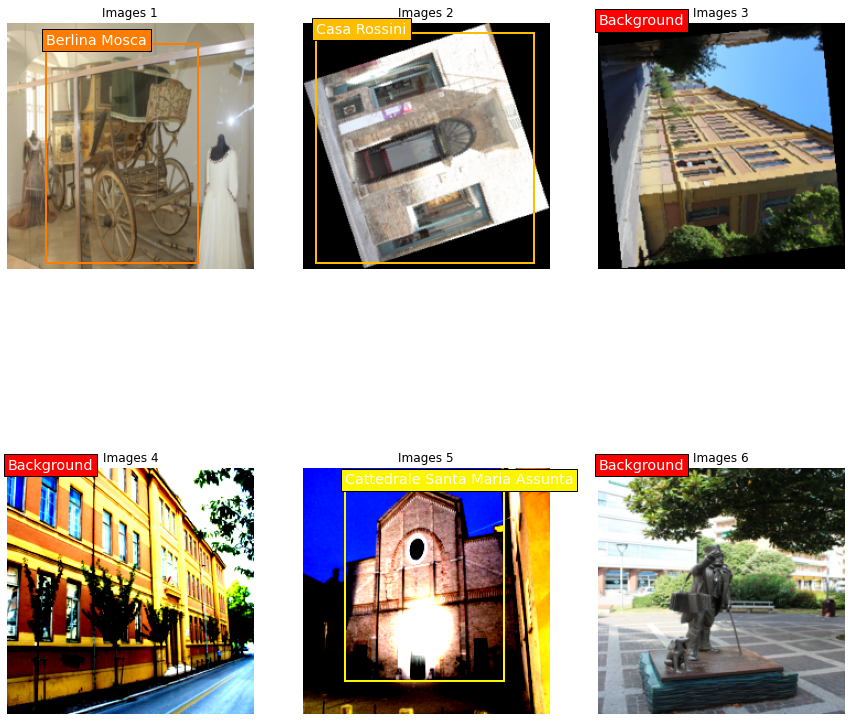

In [ ]:
if data_augmentation:
  rows = 2
  cols = 3
  num_images = 6

  images = []
  for i in range(num_images):
    start = len(train_ds) - num_imgs_data_aug
    images.extend(random.sample(range(start, len(train_ds)), 1))

  colors = plt.cm.hsv(np.linspace(0, 1, num_classes + 1)).tolist()
  _, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
  
  ix = 0
  for i in range(rows):
    for j in range(cols):
    
      img, target = train_ds[images[ix]]  
      img = img.detach().cpu().permute(1, 2, 0)
      labels = target['labels']
      boxes = target['boxes']    
      
      axs[i, j].imshow(img), axs[i, j].axis('off'),axs[i, j].set_title(f"Images {ix+1}")

      for ix_box, box in enumerate(boxes):
        xmin = box[0]
        ymin = box[1]
        xmax = box[2]
        ymax = box[3]

        label = labels[ix_box].int().item()       
        color = colors[label]
        label = '{}'.format(target2label[label])
        axs[i, j].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
        axs[i, j].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
     
      ix += 1

Definizione dei _loader_ per training, validation e test.

Per il training e validation set vengono creati mini-batch di dimensione pari a 4.

In [20]:
batch_size      = 4
batch_size_test = 1

# Training set
train_loader = DataLoader(train_ds, batch_size=batch_size, collate_fn=train_ds.collate_fn, shuffle=True, drop_last=True)

# Validation set
valid_loader = DataLoader(valid_ds, batch_size=batch_size, collate_fn=valid_ds.collate_fn, shuffle=True, drop_last=True)

# Test set
test_loader = DataLoader(test_ds, batch_size=batch_size_test, collate_fn=test_ds.collate_fn, drop_last=True)

## Faster R-CNN

### **Modello**

Fine tuning del modello pre-addestrato Faster R-CNN in base al numero di classi del problema.

Vengono inoltre definiti gli **iper-parametri** dell'addestramento.

- **get_model()**: fine tuning del modello pre-addestrato fornito da PyTorch. Il modello è stato addestrato sul dataset **COCO** caratterizzato da 80 oggetti per un totale di 330.000 immagini e 1,5 milioni di istanze di oggetti.

Architettura della rete **Faster R-CNN**.

![alt text](https://imgs.developpaper.com/imgs/1719455-20200809175322164-695603217.png)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model(num_classes):
    """ 
    Get pretrained model faster r-cnn.
    
    :param num_classes: number of problem classes.
    """

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

model = get_model(num_classes + 1).to(device)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.00005,
                             weight_decay=0.0005) 

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                                gamma=0.96,
                                                verbose=True)

n_epochs = 10
log_loss    = Report(n_epochs)  # Loss log
log_metrics = Report(n_epochs)  # Metrics log

print("** SUMMARY TRAINING **\n")
print(f"- Epochs number: {n_epochs};")
print(f"- Batch size: {batch_size};")
print(f"- Data Augmentation: {data_augmentation};")
print(f"- Optimizer: {optimizer.__class__.__name__},")
print(f"             Learning Rate: {optimizer.defaults['lr']}")

Adjusting learning rate of group 0 to 5.0000e-05.
** SUMMARY TRAINING **

- Epochs number: 10;
- Batch size: 4;
- Data Augmentation: False;
- Optimizer: Adam,
             Learning Rate: 5e-05


E' composta da 4 sotto-moduli:

- _GeneralizedRCNNTransform_: esegue un resize e una normalizzazione dell'input;

- _BackboneWithFPN_: è la backbone della rete neurale che transforma l'input in features map. In questo progetto la backbone è una **ResNet-50**;

- _RegionProposalNetwork_: genera gli anchor boxes (a partire dall'output della backbone) e restituisce un insieme di regioni di interesse (RPN);

- _RoiHeads_: restituisce per ogni RPN le probabilità per il task di classificazione e regressione.

In [ ]:
# Show architecture model
print(model)

### **Training**

Funzioni per allenare il modello.

- **train_batch()**: passo di forward e backward per ogni batch del training set.

- **validate_batch()**: calcolo della loss per ogni batch del validation set.

In [13]:
def train_batch(inputs, model, optimizer):
    """ Training batch """

    model.train()
    input, targets = inputs

    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()

    model.to(device)
    losses = model(input, targets)  # Feed-forward
    loss = sum(loss for loss in losses.values())

    loss.backward()
    optimizer.step()

    return loss, losses

@torch.no_grad()
def validate_batch(inputs, model):
    """ Validation batch """

    model.train()

    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()

    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())

    return loss, losses

#### Metriche

Poichè si tratta di un problema di object detection, le metriche utilizzate sono l'average precision (AP) e la medium average precision (mAp).

Per calcolare le metriche vengono eseguiti i seguenti passi:

- per ogni predizione si calcolano i **_True Positive_** (TP), **_False Positive_** (FP) e i **_False Negative_** (FN). Per calcolarli si considera una predizione  corretta quando la classse è giusta e l'_Intersection over Union_ (IoU) tra la bounding box predetta e quella del groundtruth è maggiore di una certa soglia (nel caso del progetto si sono scelte 2 soglie: 0.50 e 0.75).

- si calcolano la **precision** e la **recall**:

  La precision indica quanto il sistema è accurato nel fare le predizioni.

  $precision = \frac{TP}{TP + FP}$

  La recall indica quanto il sistema è selettivo.

  $recall = \frac{TP}{TP + FN}$

 
- Sulla base di queste due metriche si crea il grafico precision-recall in cui solitamente la curva viene prima corretta rimpiazzando la precision al livello della recall, come mostra l'immagine qui sotto. 

- Si calcola **l'average precision** come l'area sotto la curva precision-recall e rappresenta la media dei valori ottenuti sulla diverse soglie di IoU sulle singole classi del dataset.

- Si calcola la **medium average precision** come la media delle singole AP quindi su tutte le classi del problema.

Grafico precision-recall: sull'asse delle y è indicata la precision mentre sull'asse delle x è indicata la recall.
![alt text](https://miro.medium.com/max/700/1*zqTL1KW1gwzion9jY8SjHA.png)

Funzioni per valutare le prestazioni sul modello.

- **select_targets()**: seleziona i targets di uno specficico batch.

- **select_preds()**: ottiene le coordinate delle bouding boxes e labels dalle predizioni del modello.

- **get_preds_targets()**: utilizzata per il calcolo delle metriche. Invoca al suo interno la due funzioni: _select_targets_ e _select_preds_.

- **extract_detections_and_labels()**: mette in relazione le predizioni con i valori del ground truth.

- **compute_overlap()**: calcola l'overlapping tra due IoU.

- **compute_ap()**: modifica i valori di recall con la specifica precision.

- **compute_true_and_false_positives()**: calcola i true positive e false positive di una predizione.

- **compute_class_average_precision()**: calcola l'average precision (AP) di una specifica classe.

- **compute_medium_average_precision()**: calcola la medium average precision (mAp)

In [14]:
def select_targets(targets):
    """
    Select targets.

    :param targets  : targets to get extract bb and labels.

    :return outputs : array in this format [[ix_label, x_min, y_min, x_max, y_max], .. ]
    """

    outputs = []

    for target in targets:

      boxes   = target["boxes"].cpu().detach().numpy()
      labels  = target["labels"].cpu().detach().numpy()

      for ix, box in enumerate(boxes):
          # Box target: [ix_label, x_min, y_min, x_max, y_max]
          box = np.insert(box, 0, labels[ix])
          outputs.append(box)

    return np.array(outputs).reshape(-1, 5)

def select_preds(predictions, confidence_threshold=0.5): 
    """
    Select predictions.

    :param predictions          : prediction after feed-forward.
    :param confidence_threshold : threshold for the scores of the predictions.

    :return pred_boxes          : coordinates of all predictions.
    :return pred_labels         : indexes labels of all predictions. 
    """

    predictions = [{k: v.to(device) for k, v in p.items()} for p in predictions]

    pred_boxes  = []
    pred_labels = []

    for prediction in predictions:

      bbs = prediction['boxes'].cpu().detach().numpy()
      labels = np.array([target2label[i] for i in prediction['labels'].cpu().detach().numpy()])
      confs = prediction['scores'].cpu().detach().numpy()

      pred = list(zip(bbs, labels, confs))
      pred_thresh = [item for item in pred if item[2] > confidence_threshold]

      # Predected boxes: [x_min, y_min, x_max, y_max, conf]
      pred_boxes =  [np.append(box[0], box[2]) for box in pred_thresh] 
      pred_labels = [label2target[label[1]] for label in pred_thresh]
    
    return np.array(pred_boxes), np.array(pred_labels)

@torch.no_grad()
def get_preds_targets(inputs, model):
  """
  Select predictions and targets after feed-forward.

  :param inputs:  input of the model.
  :param model:   model net.

  :return pred_boxes          : coordinates of all predictions.
  :return pred_labels         : indexes labels of all predictions. 
  :return targets : target array in this format [[ix_label, x_min, y_min, x_max, y_max], .. ]
  """

  model.eval()

  input, _targets = inputs
  input = list(image.to(device) for image in input)
  _targets = [{k: v.to(device) for k, v in t.items()} for t in _targets]

  predictions = model(input)
 
  # Get targets
  targets = select_targets(_targets)
  
  # Get predicitons
  pred_boxes, pred_labels = select_preds(predictions, confidence_threshold=0.5)

  assert len(pred_boxes) == len(pred_labels)

  return pred_boxes, pred_labels, targets

def extract_detections_and_labels(pred_boxes, pred_labels, true_labels):
  """
  Extract detection and label among pred_boxes, pred_labels and true_labels.

  :param pred_boxes   : boxes predicted in format [x_min, y_min, x_max, y_max, conf];
  :param pred_labels  : labels predicted in format [ix_label]
  :param true_labels  : target labels and boxes in format [ix_label, x_min, y_min, x_max, y_max]

  :return detections  : list contained the boxes and score predicted for each labels at the right index.
  :return annotations : list contained the boxes target for each labels at the rigth index.
  """

  detections = [None for i in range(len(target2label))]
  labels     = [None for i in range(len(target2label))]

  l = range(1, len(target2label))

  for label in l:
      if len(pred_labels) > 0:
          detections[label] = pred_boxes[pred_labels == label, :]

  for label in l:
      if len(true_labels) > 0:
          labels[label] = true_labels[true_labels[:, 0] == label, 1:5].copy()
      else:
          labels[label] = np.array([[]])

  assert len(detections) == len(labels)
  return detections, labels

def compute_overlap(a, b):
    """
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    :param a         : (N, 4) ndarray of float
    :param b         : (K, 4) ndarray of float

    :return overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """

    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua

def compute_ap(recall, precision):
    """
    Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    :param recal              : The recall curve (list).
    :param precision          : The precision curve (list).

    :return averave precision : The average precision as computed in py-faster-rcnn.
    """
    
    # Correct AP calculation
    # First append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # Compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # To calculate area under PR curve, look for points
    # Where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # And sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def compute_true_and_false_positives(all_detections, all_annotations, label, conf_threshold=0.5):
  """
  Get TP (true positive) and FP (false positive) for each predictions.

  :param all_detections  : all lists contained the boxes and score predicted for each labels at the right index. 
  :param all_annotations : all lists list contained the boxes target for each labels at the rigth index.
  :param label           : current label.
  :param conf_threshold  : confidence threshold to calculate IoU.

  :return TP             : true positive.
  :return FP             : false positive.
  :return scores         : score of each prediction of the current label.
  :return annotations    : number of the target boxes of the current label.
  """

  false_positives = np.zeros((0,))
  true_positives = np.zeros((0,))
  scores = np.zeros((0,))
  num_annotations = 0.0

  for i in range(len(all_detections)):

      if all_detections[i] is not None:
        annotations = all_annotations[i][label]
        annotations = annotations.astype(np.float32)
        num_annotations += annotations.shape[0]

        detected_annotations = []
        detections = all_detections[i][label]

        if detections is not None:
            detections = detections.astype(np.float32)

            for d in detections:
                scores = np.append(scores, d[4])

                try:
                    annotations[0][0]

                except IndexError:
                    false_positives = np.append(false_positives, 1)
                    true_positives = np.append(true_positives, 0)
                    continue

                overlaps = compute_overlap(np.expand_dims(d, axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap = overlaps[0, assigned_annotation]
                
                if max_overlap >= conf_threshold and assigned_annotation not in detected_annotations:

                    false_positives = np.append(false_positives, 0)
                    true_positives = np.append(true_positives, 1)
                    detected_annotations.append(assigned_annotation)

                else:
                    false_positives = np.append(false_positives, 1)
                    true_positives = np.append(true_positives, 0)

  return true_positives, false_positives, scores, num_annotations

def compute_class_average_precision(true_positives, false_positives, scores, num_annotations):
  """

  :param true_positives : num of the TP.
  :param false_positives: num of the FP.
  :param scores         : score of each prediction of the current label
  :param num_annotations: number of the target boxes of the current label.

  :return ap            : average precision of the current label.
  """

  if num_annotations == 0:
      return 0
  
  ix = np.argsort(-scores)
  false_positives = false_positives[ix]
  true_positives = true_positives[ix]

  false_positives = np.cumsum(false_positives)
  true_positives = np.cumsum(true_positives)

  # Recall
  recall = true_positives / num_annotations
  
  # Precision
  precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

  return compute_ap(recall, precision)


def compute_medium_average_precision(average_precisions):
  """
  Compute the medium average precision (mAP).

  :param average_precision: all average precisions obtained.

  :return medium average precision.
  """

  count = 0

  for k in average_precisions.keys():
    count  = count + float(average_precisions[k])

  return count / len(range(1, len(target2label)))

#### Early stopping

Poichè PyTorch non dispone di una callback per implementare l'early stopping, ho deciso di realizzare una piccola classe per questo task.

In questo modo è possibile controllare l'overfitting durante l'addestramento.

In [15]:
class EarlyStopping:
    """
    Class that implements early stopping to end network training to avoid the overfitting.
    """

    def __init__(self, patience=5):
        """
        Constructor of class.

        :param patience: number of epochs to wait to finish the training.
        """

        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):

        if self.best_loss is None or val_loss < self.best_loss:

            # Update the best loss field
            self.best_loss = val_loss
            self.counter = 0

        elif val_loss == self.best_loss:
            self.counter = 0

        elif val_loss > self.best_loss:

            self.counter += 1
            print(f"\n[WARNING] Early stopping {self.counter}/{self.patience}")

            if self.counter == self.patience:
                print('\n[EARLY STOPPING] --> Stop training')
                self.early_stop = True

#### Training loop

_Script_ per addestrarre il modello.

In [21]:
all_average_precision_50 = []
all_average_precision_75 = []

early_stopping = EarlyStopping(patience=3)

for epoch in range(n_epochs):

    if lr_scheduler is not None:
      current_lr = lr_scheduler.get_last_lr()
      print(f"\nEpoch {epoch + 1}) Learning rate: {current_lr}")

    ## Training loop ##
    _n = len(train_loader)

    for ix, inputs in enumerate(train_loader):

        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]

        pos = (epoch + (ix+1)/_n)
        log_loss.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    ## Validation loop ##
    _n = len(valid_loader)
    losses_validation   = []

    # Preparing data to get metrics
    all_detections  =  [None for i in range(0, len(valid_loader))]
    all_annotations =  [None for i in range(0, len(valid_loader))]

    for ix, inputs in enumerate(valid_loader):

        loss, losses = validate_batch(inputs, model)

        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]

        pos = (epoch + (ix+1)/_n)
        losses_validation.append(loss.item())

        log_loss.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
        
        ## Metrics ##
        pred_boxes, pred_labels, true_labels = get_preds_targets(inputs, model)
        detections, annotations = extract_detections_and_labels(pred_boxes, pred_labels, true_labels)
      
        all_detections[ix]  = detections
        all_annotations[ix] = annotations
        
    early_stopping(statistics.mean(losses_validation))
        
    confidence_IoU = [0.5, 0.75]   # Different overlap IoU

    for conf in confidence_IoU:
      average_precisions = {}

      for label in range(1, len(target2label)):

        true_positives, false_positives, scores, num_annotations = compute_true_and_false_positives(all_detections, all_annotations, label, conf)
        ap = compute_class_average_precision(true_positives, false_positives, scores, num_annotations)

        assert 0 <= ap <= 1
        average_precisions[target2label[label]] = ap

      # AP e mAP
      mAp = compute_medium_average_precision(average_precisions)

      if conf == 0.5:
        all_average_precision_50.append(average_precisions)
        log_metrics.record(epoch + 1, mAp50 = mAp, end='\r')
        print("\nmAP 0.50: ", mAp, end="\n")
      else:
        all_average_precision_75.append(average_precisions)
        log_metrics.record(epoch + 1, mAp75 = mAp, end='\r')
        print("\nmAP 0.75: ", mAp, end="\n")

    if lr_scheduler is not None:
      lr_scheduler.step()
        
    if (epoch + 1) % (n_epochs // 10) == 0:
        log_loss.report_avgs(epoch + 1)

    name = f"{epoch + 1}-FasterRCNNCulturalHeritage.pth"

    if lr_scheduler is None:
      torch.save({
                'epoch': epoch + 1,
                'model': model.to("cpu").state_dict(),
                'optimizer': optimizer.state_dict()
                }, name)
    else:
      torch.save({
          'epoch': epoch + 1,
          'model': model.to("cpu").state_dict(),
          'optimizer': optimizer.state_dict(),
          'scheduler': lr_scheduler.state_dict()
          }, name)
      
    if early_stopping.early_stop:
      break


Epoch 1) Learning rate: [5e-05]
EPOCH: 1.000	trn_loss: 0.257	trn_loc_loss: 0.094	trn_regr_loss: 0.153	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.003	(627.50s - 5647.50s remaining){'loss_classifier': tensor(0.0839), 'loss_box_reg': tensor(0.1161), 'loss_objectness': tensor(0.0180), 'loss_rpn_box_reg': tensor(0.0034)}
EPOCH: 0.500	val_loss: 0.221	val_loc_loss: 0.084	val_regr_loss: 0.116	val_objectness_loss: 0.018	val_rpn_box_reg_loss: 0.003	(648.21s - 12315.98s remaining){'loss_classifier': tensor(0.0989), 'loss_box_reg': tensor(0.0819), 'loss_objectness': tensor(0.0089), 'loss_rpn_box_reg': tensor(0.0044)}
EPOCH: 1.000	mAp50: 0.062	(707.74s - 6369.70s remaining)
mAP 0.50:  0.0625
EPOCH: 1.000	mAp75: 0.000	(707.75s - 6369.72s remaining)
mAP 0.75:  0.0
Adjusting learning rate of group 0 to 4.8000e-05.
EPOCH: 1.000	trn_loss: 0.529	trn_loc_loss: 0.290	trn_regr_loss: 0.132	trn_objectness_loss: 0.091	trn_rpn_box_reg_loss: 0.015	val_loss: 0.221	val_loc_loss: 0.084	val_regr_loss: 0.116

KeyboardInterrupt: ignored

#### Grafici

Grafico loss

Viene mostrato il grafico della loss del training e validation set.

100%|██████████| 105/105 [00:00<00:00, 1976.45it/s]


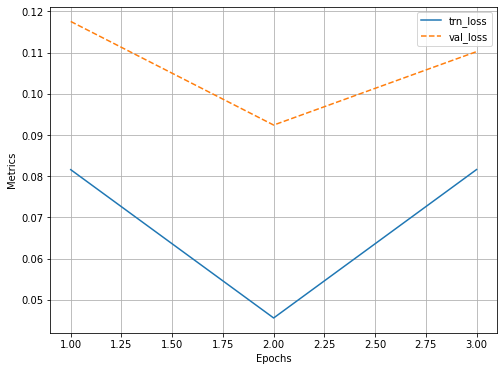

In [ ]:
log_loss.plot_epochs(['trn_loss','val_loss'])

Grafici metriche

In questa sezione viene mostrato il grafico della mAp con IoU pari a 0.50 e pari a 0.75.

Inoltre viene mostrato il grafico dell'andamento delle 4 migliori AP sempre con IoU pari a 0.50 e pari a 0.75.

- **get_max_average_precision_by_key()**: restituisce i 4 migliori valori di una specifica AP.

- **get_max_average_precision()**: calcola quali sono le migliori classi con AP più alta.

- **plot_average_precisions()**: mostra il grafico delle migliori 4 AP.

In [ ]:
def get_max_average_precision_by_key(ap, max_values):
  """
  Get max value from average precision.

  :param ap         : average precision of all labels.
  :param max_values : first 4 largest values of ap.

  :return list contains lists of the first 4 ap with max values.
  """

  max_ap = np.array([])
  if len(max_values) == 4:
    max_1, max_2, max_3, max_4 = max_values
  

    # Get first max
    keys_values_1 = [label2target[max_1[0]]]
    keys_values_2 = [label2target[max_2[0]]]
    keys_values_3 = [label2target[max_3[0]]]
    keys_values_4 = [label2target[max_4[0]]]

    for item in ap:
      keys_values_1.append(item[max_1[0]])
      keys_values_2.append(item[max_2[0]])
      keys_values_3.append(item[max_3[0]])
      keys_values_4.append(item[max_4[0]])

    max_ap = np.array([keys_values_1, keys_values_2, keys_values_3, keys_values_4])  

  return max_ap

def get_max_average_precision(ap_iou_50, ap_iou_75):
  """
  Get max average precision for average precision with IoU overlap equal to 0.5 and 0.75.

  :param ap_iou_50            : average precision with overlap IoU equal to 0.5.
  :param ap_iou_75            : average precision with overlap IoU equal to 0.75.

  :return largest_values_ap_50: first 4 max values for average precision with overlap IoU equal to 0.5.
  :return largest_values_ap_75: first 4 max values for average precision with overlap IoU equal to 0.75.
  """
  
  max_ap_iou_50 = Counter()
  max_ap_iou_75 = Counter()

  if isinstance(ap_iou_50, dict):
    ap_iou_50 = [ap_iou_50]
    ap_iou_75 = [ap_iou_75]

  ap_zipped = zip(ap_iou_50, ap_iou_75)    

  # Order by max value ap on iou 0.50, 0.75
  for _ap_iou_50, _ap_iou_75 in ap_zipped:
    max_ap_iou_50.update(_ap_iou_50)
    max_ap_iou_75.update(_ap_iou_75)

  # Get the first 4 largest values

  # IoU 0.50
  if len(max_ap_iou_50) > 0:
    max_ap_iou_50 = max_ap_iou_50.most_common(4)
    largest_values_ap_50 = get_max_average_precision_by_key(ap_iou_50, max_ap_iou_50)
  else:
    largest_values_ap_50 = np.array([[], [], [], []])

  # IoU 0.75
  if len(max_ap_iou_75) > 0:
    max_ap_iou_75 = max_ap_iou_75.most_common(4)  
    largest_values_ap_75 = get_max_average_precision_by_key(ap_iou_75, max_ap_iou_75)
  else:
    largest_values_ap_75 = np.array([[], [], [], []])

  return largest_values_ap_50, largest_values_ap_75

def plot_average_precisions(ap, n_epochs, overlap_iou):
  """
  Plot first 4 average precision largest with IoU overlap.

  :param ap: first 4 average precision largest.
  :param n_epoch: total number of epochs.
  :param overlp_iou: overlap intesection over union.
  """
  
  values_ap = []
  for _ap in ap:

    if len(_ap) > 0:
      _ap = list(_ap)
      label = target2label[_ap[0]]
      if len(label) > 10:
        label = label[:10]
      values_ap.append([label, _ap[1:]])
    else:
      continue

  if len(values_ap) > 0:
    max_1, max_2, max_3, max_4 = values_ap

    plt.plot(range(1, n_epochs +1), max_1[1:][0], color='r', label=max_1[0])
    plt.plot(range(1, n_epochs +1), max_2[1:][0], color='b', label=max_2[0])
    plt.plot(range(1, n_epochs +1), max_3[1:][0], color='g', label=max_3[0])
    plt.plot(range(1, n_epochs +1), max_4[1:][0], color='m', label=max_4[0])

    plt.xlabel('Epoch number')
    plt.ylabel('Average Precision')
    plt.legend(loc="upper left")
    plt.title(f'First 4 average precision largest with IoU overlap equal to {overlap_iou}')
    plt.show()

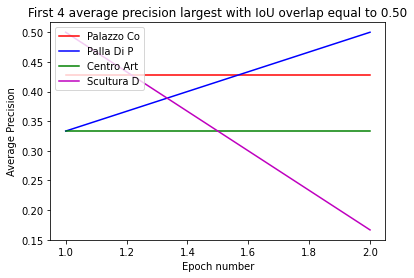

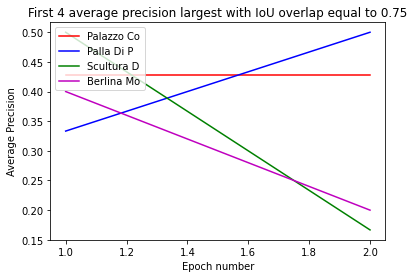

100%|██████████| 105/105 [00:00<00:00, 78447.08it/s]


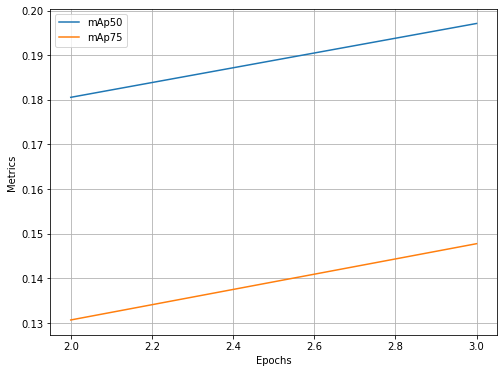

In [ ]:
max_ap_50, max_ap_75 = get_max_average_precision(all_average_precision_50, all_average_precision_75)

plot_average_precisions(max_ap_50, n_epochs, "0.50")
plot_average_precisions(max_ap_75, n_epochs, "0.75")

log_metrics.plot_epochs(["mAp50", "mAp75"])

#### Addestramenti effettuati

La tabella seguente inidica gli **iperparametri** utilizzati per ogni addestramento e le prestazioni ottenute.

La colonna _DA_ indica se la _Data Augmentation_ è stata applicata sul training set 

La colonna _Img Train_ indica le immagini utilizzate per il training set.

Numero|Epoche|Ottimizzatore|LR|Scheduler|Batch size|DA|Img Train|mAp (IoU 0.50)|mAp (IoU 0.75)  
-|----- |-------------|-------|-----------|---|--|-----|--------| ------|
1|10    |  Adam       |0.00005  | //     | 4 |No|657  |0.22| 0.18|
||||||      
2|15    |  Adam       |0.00005  | Exponential     | 4 | No|657|0.22| 0.17|
|||||
3|15    |  RMSprop       |0.00005  | Exponential | 4 | No|657|0.24| 0.18|
|||||
4|10    |  Adam       |0.00005  | // | 4 | Si |1467|0.21| 0.14|
||||||||
5|10    |  Adam       |0.00005  | Exponential | 4 | Si |1611|0.20| 0.15|
||||||||


----------
Note

 - Come si può notare dalla tabella, gli addestramenti sono stati effettuati con ottimizzatori adattattivi. Questo perchè i dati di training sono dati sparsi risultando non adeguati all'addestramento con altri ottimizzatori come **SGD**.

- Il learning rate iniziale è di $5 * 10^{-5}$ che è l'unico lr per cui si ottengono performance accetabili. Prove sperimentali hanno dimostrato che l'uso di lr più alti portano ad una divergenza dell'algoritmo di training.

Visualizzazione dei grafici dei vari addestramenti effettuati.

Ogni riga si riferisce ad un modello differente in accordo con la tabella precedente. I grafici indicano nell'ordine:

- loss function di training e validation set;
- medium average precision calcolata considerando un IoU pari 0.50 e 0.75;
- le migliori 4 average precision calcolate su un IoU pari 0.50.
- le migliori 4 average precision calcolate su un IoU pari 0.75.

Grafici disponibili al seguente [link](https://drive.google.com/drive/folders/1PWv5C8og7aP8oufuP0ThJTgoc7gtYdtD?usp=sharing).

In [ ]:
path_images = "/content/drive/MyDrive/Colab Notebooks/Cultural Heritage/imgs"  # Replace with your path

folders = ["losses", "mediumAP", "AP_0.50", "AP_0.75"]
dirs = natsort.natsorted(os.listdir(path_images))

dir_loss = natsort.natsorted(os.listdir(path_images+"/"+folders[0]))
dir_mAp = natsort.natsorted(os.listdir(path_images+"/"+folders[1]))
dir_ap_50 = natsort.natsorted(os.listdir(path_images+"/"+folders[2]))
dir_ap_75 = natsort.natsorted(os.listdir(path_images+"/"+folders[3]))

images = [dir_loss, dir_mAp, dir_ap_50, dir_ap_75]

rows = 4
cols = 4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(45, 45))

for i in range(rows):
  for j in range(cols):

    source = images[j]
    img = cv.imread(f"{path_images}/{folders[j]}/{source[i]}")  
    axes[i, j].imshow(img)

### **Prediction**

In questa sezione è possibile visualizzare le predizioni e prestazioni fatte dal modello.

- **print_performance()**: mostra a video i valori delle 4 migliori AP;

In [ ]:
def print_performance(max_values, iou_threshold):
  """
  Show first 4 values larget of the average precision.
  """

  if len(max_values) == 4:
    max_1, max_2, max_3, max_4 = max_values

    print(f"Average precision with overlap IoU {iou_threshold}:\n"\
          f"1- {target2label[max_1[0]]}: {max_1[1]}\n" \
          f"2- {target2label[max_2[0]]}: {max_2[1]}\n" \
          f"3- {target2label[max_3[0]]}: {max_3[1]}\n" \
          f"4- {target2label[max_4[0]]}: {max_4[1]}\n\n")

Vengono mostrate le immagini del test set con le predizioni del modello.

Average precision with overlap IoU 0.5:
1- Arco Di Trionfo: 1.0
2- Casa Rossini: 1.0
3- Chiesa San Agostino: 1.0
4- Palazzo Baviera: 1.0


Average precision with overlap IoU 0.75:
1- Arco Di Trionfo: 1.0
2- Casa Rossini: 1.0
3- Chiesa San Agostino: 1.0
4- Palazzo Baviera: 1.0


Medium average precision:
	-IoU 0.50: 0.4861111111111111
	-IoU 0.75: 0.4236111111111111




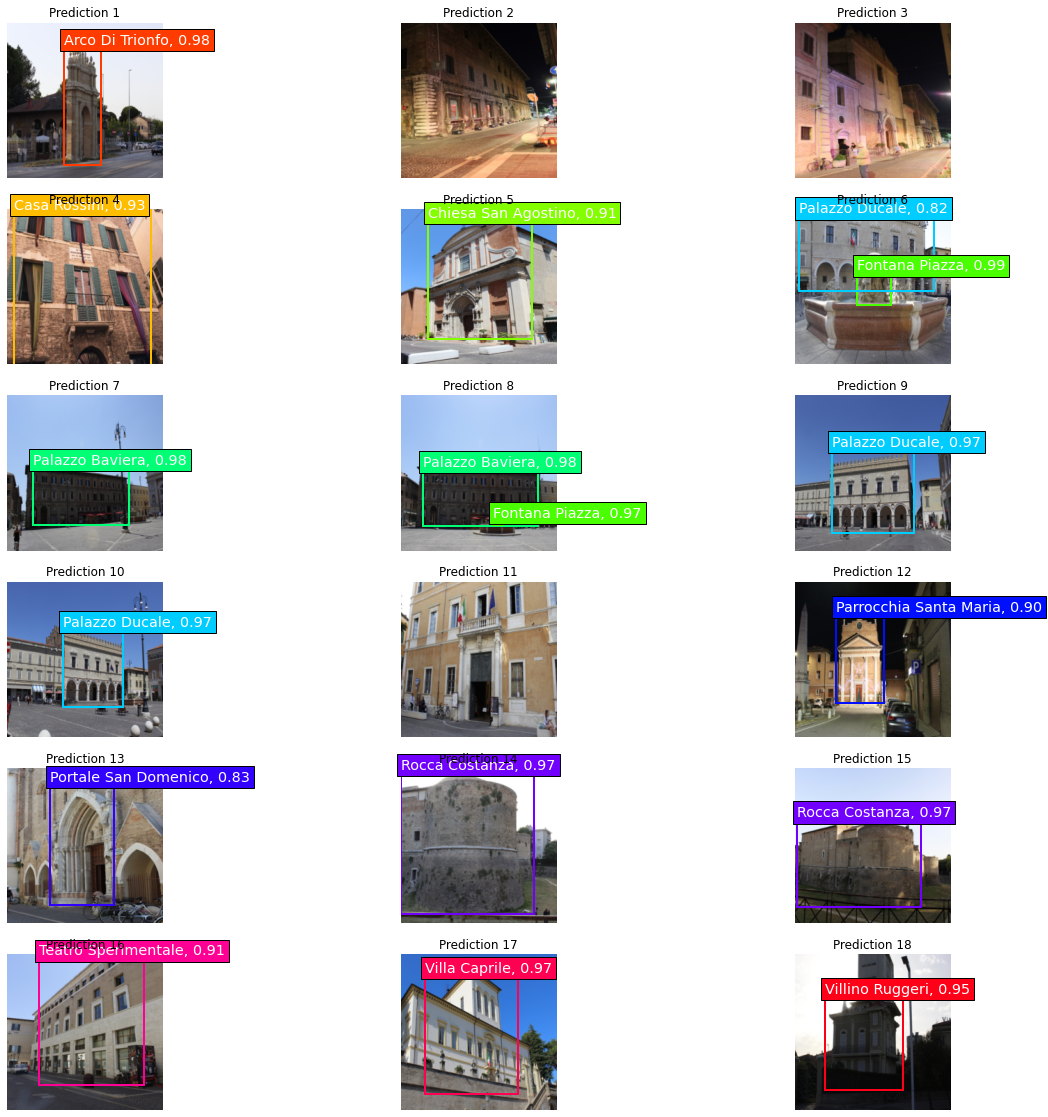

In [ ]:
# Load model.

# The models refer to the previous table.
load_model = True
path    = "/content/drive/MyDrive/Colab Notebooks/Cultural Heritage/models/"
model   = "1-FasterRCNNCulturalHeritage.pth"      # Adam, no scheduler rate, no data augmentation
#model   = "2-FasterRCNNCulturalHeritage.pth"      # Adam, exponential scheduler rate, no data augmentation
#model   = "3-FasterRCNNCulturalHeritage.pth"      # RMSProp, exponential scheduler rate, no data augmentation
#model   = "4-FasterRCNNCulturalHeritage.pth"      # Adam, no scheduler rate, si data augmentation
#model   = "5-FasterRCNNCulturalHeritage.pth"      # Adam, exponential scheduler rate, si data augmentation

if load_model:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model_loaded = torch.load(path + model, map_location=torch.device('cpu'))
  model = get_model(num_classes + 1).to(device)
  model.load_state_dict(model_loaded['model'])

#####################################

# Prediction
model.eval()

rows = 6
cols = 3
n_images = 18

all_detections  = [None for i in range(0, n_images)]
all_annotations = [None for i in range(0, n_images)]
time_predictions= [None for i in range(0, n_images)]

colors = plt.cm.hsv(np.linspace(0, 1, num_classes + 1)).tolist()
_, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))

random_index = random.sample(range(len(test_loader)), n_images)

count, r, c = 0, 0, 0
for ix, data in enumerate(test_loader):

    if ix in random_index and count <= n_images:

      images, targets = data
      images = [im for im in images]
      model.to(device)

      start = time.time()
      outputs = model(images)
      end = time.time()
      time_predictions[count] = end - start

      # Get metrics
      targets = select_targets(targets)
      pred_boxes, pred_labels = select_preds(outputs, confidence_threshold=0.60)

      assert len(pred_boxes) == len(pred_labels)

      detections, annotations = extract_detections_and_labels(pred_boxes, pred_labels, targets)

      all_detections[count]  = detections
      all_annotations[count] = annotations

      labels  = []
      bbs     = []
      confs   = []

      for i, item in enumerate(zip(pred_labels, pred_boxes)):
        
        label, bb = item 
        bb, conf = bb[:-1], bb[-1]

        labels.append(label)
        bbs.append(bb)
        confs.append(conf)
    
      axs[r, c].imshow(images[0].cpu().permute(1,2,0)), axs[r, c].axis('off'),axs[r, c].set_title(f"Prediction {count+1}")

      if len(bbs) != 0:
        for ix_box, box in enumerate(bbs):
          xmin = box[0]
          ymin = box[1]
          xmax = box[2]
          ymax = box[3]

          label = labels[ix_box] 
          color = colors[label]
          label = '{}, {:.2f}'.format(target2label[label], confs[ix_box])
          axs[r, c].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
          axs[r, c].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

      count += 1
      if c != 2:
        c += 1
      else:
        r += 1
        c = 0

# Different overlap IoU     
confidence_IoU = [0.5, 0.75] 
mAps = []
aps = []

for conf in confidence_IoU:
  average_precisions = {}

  for label in range(1, len(target2label)):
    
    true_positives, false_positives, scores, num_annotations = compute_true_and_false_positives(all_detections, all_annotations, label, conf)
    ap = compute_class_average_precision(true_positives, false_positives, scores, num_annotations)
    
    assert 0 <= ap <= 1
    average_precisions[target2label[label]] = ap

  # AP e mAP
  mAp = compute_medium_average_precision(average_precisions)
  aps.append(average_precisions)
  mAps.append(mAp)
  
max_ap_50, max_ap_75 = get_max_average_precision(aps[0], aps[1])

print_performance(max_ap_50, 0.50)
print_performance(max_ap_75, 0.75)

print(f"Medium average precision:\n\t-IoU 0.50: {mAps[0]}\n\t-IoU 0.75: {mAps[1]}\n\n")

Tempo medio di predizione del modello su una immagine.

In [ ]:
print(f"Tempo medio di predizione: {statistics.mean(time_predictions)} sec.")

Tempo medio di predizione: 0.2730075404757545 sec.


## Modelli addestrati

I modelli addestrati possono essere scaricati dal seguente [link](https://drive.google.com/drive/folders/1zoQe3hdZ5DnUyr_lUdVS4WOYOvDBMbPJ?usp=sharing).

## Celle di prova

In [ ]:
# Load model pytorch
#path = f"/content/drive/MyDrive/Colab Notebooks/Cultural Heritage/models/2-FasterRCNNCulturalHeritage.pth"
path = "drive/MyDrive/8-FasterRCNNCulturalHeritage.pth"
#path = "11-FasterRCNNCulturalHeritage.pth"

model_loaded = torch.load(path, map_location=torch.device('cpu'))

model = get_model(num_classes + 1).to(device)
model.load_state_dict(model_loaded['model'])
optimizer.load_state_dict(model_loaded['optimizer'])
lr_scheduler.load_state_dict(model_loaded['scheduler'])

In [ ]:
!cp 2-FasterRCNNCulturalHeritage.pth /content/drive/MyDrive

In [ ]:
name = "11-FasterRCNNCulturalHeritage.pth"
torch.save({
          'epoch': 10,
          'model': model.to("cpu").state_dict(),
          'optimizer': optimizer.state_dict(),
          'scheduler': lr_scheduler.state_dict()
          }, name)